In [8]:
import pandas as pd
import numpy as np
import datetime

import warnings
warnings.simplefilter(action='ignore')


pd.options.display.max_columns =  None

# Introduction

Originally this project arose as a part of a wider task. During the process of deployment sales forecasting program in one famous beer company it turned out that some sensitive information about promo(discount)  types was missed. 

Overall, there are two discount types used in the company - regular promos and shelf-life promos. Their reasons of approving are fundamentally different. Regular promos are given to promote consumption and provide competitive prices to clients (what is in the sense the same), while approving shelf-life discounts aims to prevent risk of writing-off goods. Correct information about promo types is crucial for proper training of forecasting algorithms, because there is a noticeable difference between growing sales due to providing regular discounts or shelf-life discounts. 

But unfortunately, labeled data was available for very limited timeframe. So, our purpose was to find a way to restore information about promo types for previous periods basing on available discount records with correctly specified types. Such a task refers to supervised classification problem, since here there are some labeled samples and some other ones, which we need to classify correctly. There are many machine-learning methods, which allows to do that, so in this work we have experimented with some of them trying to find out an approach which best fits to our problem.

# Preprocessing

### Import promo data

In [27]:
#you can set differnt path if it's necessary
full_promo_path = 'full_promo.csv'

full_promo = pd.read_csv(full_promo_path, delimiter=';', parse_dates  = [4,5,6])

full_promo -  it is a culmulative xlsx file with information about approved promos withing period [20.02.24,31.03.24]. It is formed from 3 other promo files for Febriary, March and April.

Columns definitions:

0. file_name - name of the of source file from which considering row is taken. Values have a format "month_year.xlsx", where month and year define time frame of the approval period.
1. file_index - promo index in the initial file
2. Type - promo type(Promo - regular promo, Shelf life -  short expiration date). It is a target variable
3. client_code - client code
4. start - promo start date
5. end - promo end date
6. shelf - starting of realization goods with promo prices in shops
7. shelf_life - product shelf_life
8. SKU_code -product code
9. amount - discount size in %
10. plan - promo realization plan

### Perform some intitial preprocessing operations

In [4]:

def adjust_promo_period(x):
  #set correct dates for month promo if thera are one-day mistakes in the endpoints
    start = x.start
    end = x.end
    if end.month - start.month == 1:
        if (start.day == 26 and end.day == 26) or (start.day == 25 and end.day == 26) or (start.day == 25 and end.day == 25):
            x.start = datetime.date(start.year, start.month, 26)
            x.end = datetime.date(end.year, end.month, 25)
    return x

#extract month and year and place them in separate columns
full_promo['file_name']= full_promo.file_name.str.replace('.xlsx', '', regex=True).str.split('_')
full_promo.insert(1, 'month', full_promo.file_name.apply(lambda x: x[0]))
full_promo.file_name = full_promo.file_name.apply(lambda x: x[1])
full_promo.rename(columns = {'file_name':'year'}, inplace = True)

#extract dates from corresponding column
full_promo.start = full_promo.start.apply(lambda x: x.date())
full_promo.end = full_promo.end.apply(lambda x: x.date())
full_promo.shelf = full_promo.shelf.apply(lambda x: x.date())

#convert year, month, tax to proper types
full_promo[['year', 'month', 'file_index']] = full_promo[['year', 'month', 'file_index']].astype(int)

#preprocess date columns
full_promo.start = full_promo.start.apply(lambda x: datetime.date(2024, x.month, x.day) if x.year != 2024 else x)
full_promo.end = full_promo.end.apply(lambda x: datetime.date(2024, x.month, x.day) if x.year != 2024 else x)
full_promo.shelf = full_promo.shelf.apply(lambda x: datetime.date(2024, x.month, x.day) if x.year != 2024 else x)

#correct popular mistakes with endpoints in regular promo
promo = full_promo.apply(adjust_promo_period, axis = 1)

#delete columns where start > end
del_index = full_promo.query('start > end').index
full_promo.drop(index=del_index, inplace = True)

#remove duplications
full_promo.drop_duplicates(['client_code', 'SKU_code', 'start', 'end', 'amount'], keep ='last', inplace = True)


#leave only last version of one-day promos
one_day_promo = full_promo[full_promo.end - full_promo.start == datetime.timedelta(days = 1)]
ver_dupl_index = one_day_promo[one_day_promo.duplicated(['client_code','SKU_code','start', 'end'], keep ='last')].index
full_promo.drop(index=ver_dupl_index, inplace = True)


#sort rows
full_promo.sort_values(['year', 'month', 'file_index'], inplace = True, ignore_index=True)

#reindex frame to eliminate spaces from the deleted rows
full_promo.reset_index(drop=True, inplace = True)

### Dates corrections

Given dataset contains intersections, which refer to the situations when for the same client and product two or more promos are active for at least one day. In such cases the last approved promo(having higher index) is applied.

**Example**

promo1 = {id: 100, "client": "BeerShop", "product": "light_beer", "start": 21.01.14, "end": 27.01.24, "size": 0.2},

promo2 = {id: 200, "client": "BeerShop", "product": "light_beer", "start":26.01.24, "end": 25.02.24, "size" = 0.25},

According to the above rule we have that promo1 is active from 21.01.24 till 25.01.24 and promo2 is active from 26.01.24 till 25.02.24.


---



From the example it follows, that the general way to understand which promo is active for the considering date is just taking the last downloaded promo. So end dates of the intersected promos should be adjusted accordingly. Our classification task doesn't require knowing true promo distribution, that is why we won't delete intersections. Even more changing promos endpoints will introduce additional bias in the date. Because after such corrections we will classify promos with not originally approved promo periods, what may be quite misleading.

However information about intersection size can be used. In other words, if one promo overlaps another one, then we can calculate size of the intersection and save this information in the row(promo) with higher index. This information can't be saved in the row with smaller index, because otherwise it will mean propagating data from the future to the past. When you approve promo you never know whether it will be overlapped by another promo in the future or not. You only know whether new promo overlaps any older one or not.


Another important thing regarding time features of promo is the fact that promo start day are not always correct. It happens mostly because managers like copy-past rows from the previously approved promos forgetting to adjust starting dates accordingly(they are more concerned about promo size and end date). CRM accepts such promos even if their starting dates are less than the date of their downloading to the system. Unfortunately, there is no information about approval dates, so we can't approximate starting dates with them.  The only thing we know is that, if two starting dates coincide, then it is mistake, so the true starting date of the promo with higher id is greater than the starting day of the promo with smaller id.

In such situation we approximate starting and ending dates of overlapping dates the following way:


start1,end1- endpoints of promo with smaller id\
start2,end2 - endpoints  of promo with greater id\


if start1 == start2:\
&nbsp; dif = (end1 - start1 + 1_day)\
&nbsp; end1 = end1 - dif\
&nbsp; start2 = end1+1_day      
        
Such approximation is a different thing rather that intersection problem. Because here we just correct managers mistakes but not modify promo periods themself. As such these ccorrections are acceptable and needed.
       


In [5]:
def group_promo(promo):
  #returns ids of consecutive promos for the same client and product
  grouped = promo.groupby(['client_code', 'SKU_code'], as_index=True).agg(lambda x: x.tolist())
  grouped = grouped[['id']]
  grouped = grouped[grouped.id.apply(lambda x: len(x) > 1)]
  grouped.reset_index(inplace = True, drop = True)
  return grouped.id.values

def check_id_groups(train_promo, id_grouped, intersections = False, periods = False):
  #check that conditions start1 <= start2 & end1 <= end2 & start1 <= end1 & start2 <= end2
  #holds for all promo.
  #If periods == True finds all id2 such that start2 < start1 or end2 < end1
  delete_index = []

  for id_list in id_grouped:

    n = len(id_list)
    k = 0
    for i in range(1,n):
        id1 = id_list[k]
        id2 = id_list[i]

        start1 = train_promo.loc[id1, 'start']
        start2 = train_promo.loc[id2, 'start']
        end1 = train_promo.loc[id1, 'end']
        end2 = train_promo.loc[id2, 'end']

        if not periods:
          assert (start1 <= start2), f'improper start points IDs:{id1}, {id2}'
          assert (end1 <= end2), f'improper end points IDs:{id1}, {id2}'
          assert (start1 <= end1), f'start > end ID:{id1}'
          assert (start2 <= end2), f'start > end ID:{id2}'

          if intersections:
            assert (end1 < start2), f'intersection ID1:{id1}, ID2:{id2}'
          k+=1

        else:
          if (start1 > start2)or(end1 > end2):

            delete_index.append(id2)
          else:
            k+=1
  if periods:
    return delete_index


def correct_promo(train_promo, id_grouped,  remove_intersections = False):
  #performs some corrections for given promo dataframe: correct mistake is starting date, find intersections size, remove intersections(optionally)
  #if remove_intrs == True  ajust promo dates to remove intersections
  #train_promo - original dataframe with promo data
  #id_grouped - indexes grouped by client and product

  check_id_groups(train_promo, id_grouped)

  for id_list in id_grouped:
    n = len(id_list)


    for i in range(1,n):
        id1 = id_list[i-1]
        id2 = id_list[i]

        start1 = train_promo.loc[id1, 'start']
        start2 = train_promo.loc[id2, 'start']
        end1 = train_promo.loc[id1, 'end']
        end2 = train_promo.loc[id2, 'end']

        #if on the previous step prev_start1 == prev_start2==prev_start3 , then on the new step condition new_start1 <= new_start2 is violated,
        #since we know that such situation is caused by our edition of datepoints we can consider new_start1 as a correct date
        if start1 > start2:
          start2 = start1

        day = datetime.timedelta(days = 1)

        if start1 == start2:
            if (end1 - start1).days == 0:
                if (end2 - start2).days == 0:
                    #such exceptions can be raised only if the given dataset conatins one-day duplications
                    #but all such duplicates were previously removed, so no exceptions should occure
                    raise Exception('two consecutive one-day overlapping promos')
            end1_ = end1
            if i < n-1:
              #this condition is checked to ensure that after update condition start2 <= start3 will be hold
              id3 = id_list[i+1]
              start3 = train_promo.loc[id3, 'start']
              end1 = min(end1, start3)
            dif = ((end1 - start1 + day)/2).days
            dif = datetime.timedelta(days = dif)
            end1 = end1 - dif
            start2 = end1 + day
            dif_ = (end1_ - end1).days
            if remove_intersections:
              train_promo.loc[id1, 'end'] = end1
            train_promo.loc[id2, 'start'] = start2
            train_promo.loc[id1, 'intr'] = id2
            train_promo.loc[id2, 'intr'] = id1
            train_promo.loc[id2, 'dif'] = dif_


        if  start2 <= end1:
          dif = (end1 - start2 + day).days
          end1 = start2 - day
          if remove_intersections:
            train_promo.loc[id1, 'end'] = end1
          train_promo.loc[id1, 'intr'] = id2
          train_promo.loc[id2, 'intr'] = id1
          train_promo.loc[id2, 'dif'] = dif

promo = full_promo.copy()

#id column represents promo frameindex
promo.insert(0, 'id', promo.index)

#group promo
id_grouped = group_promo(promo)

#find and delete promo2 in groups such that start2 < start1 or end2 < end1
delete_index = check_id_groups(promo, id_grouped, periods = True)
promo.drop(index=delete_index, inplace = True)

#reindex frame to eliminate spaces from the deleted rows
promo.reset_index(drop=True, inplace = True)

#update id column
promo.id = promo.index

promo_copy = promo.copy()
promo_copy.rename(columns = {'id': "id_","SKU_code":"SKU_code_",'client_code':'client_code_','start':'start_', 'end':'end_'}, inplace = True)


#intr - saves id of the other promo in the intersection pair
#dif - intersection size, saved for id2 only
promo.insert(9, 'intr', np.nan)
promo.insert(9, 'dif', 0)



id_grouped = group_promo(promo)
correct_promo(promo, id_grouped, remove_intersections=False)
#additionally check that there are no intersections
check_id_groups(promo, id_grouped, intersections=False)

#visualize results
promo_concat = pd.concat([promo_copy, promo], axis = 1)
promo_concat = promo_concat[['client_code', 'SKU_code',  'start_', 'start', 'end_', 'end',
       'dif',  'intr']]

#visualise results
promo_concat[promo_concat.dif.notna()]

,client_code,SKU_code,start_,start,end_,end,dif,intr
0,Nd-00021574,60503,2024-02-21,2024-02-21,2024-02-25,2024-02-25,0,NaN
1,Nd-00021574,89423,2024-02-21,2024-02-21,2024-02-25,2024-02-25,0,NaN
2,88,91602,2024-02-21,2024-02-21,2024-02-25,2024-02-25,0,NaN
3,88,85741,2024-02-21,2024-02-21,2024-02-25,2024-02-25,0,NaN
4,Nd-00020174,85741,2024-02-21,2024-02-21,2024-02-25,2024-02-25,0,NaN
...,...,...,...,...,...,...,...,...
5990,349,71875,2024-04-01,2024-04-01,2024-04-25,2024-04-25,0,NaN
5991,150,104309,2024-04-01,2024-04-01,2024-04-25,2024-04-25,0,NaN
5992,150,1003611,2024-04-01,2024-04-01,2024-04-25,2024-04-25,0,NaN
5993,150,87800,2024-04-01,2024-04-01,2024-04-25,2024-04-25,0,NaN


### Perform some additional manipulations with promo columns

In [6]:

#after correcting start_days find full promo length
promo_len = promo.end - promo.start + datetime.timedelta(days = 1)
promo_len = promo_len.apply(lambda x: x.days)
promo.insert(10, 'promo_len', promo_len)


#shelf_dif - represents a gap between end and shelf date
shelf_dif = promo.shelf - promo.start
shelf_dif = shelf_dif.apply(lambda x: x.days)
promo.insert(11, 'shelf_dif', shelf_dif)
promo.shelf_dif = promo.shelf_dif.apply(lambda x: 0 if x < 0 else x)



#to be able correctly compare promos from files with different sizes we need to replace absolute position on relative one
promo_grouped = promo.groupby(['year', 'month'])
max_index = promo_grouped['file_index'].transform('max')
rel_pos = (promo.file_index / max_index).round(4)
promo.insert(3,'rel_pos', rel_pos)

#drop unnecessary columns
promo.drop(columns = [ 'intr','file_index', 'shelf', 'id'], inplace = True)

### Improt short expiration data

In [50]:
#you can set different path if it's necessary
short_exp_path = 'short_exp_goods.csv'
short_exp = pd.read_csv(short_exp_path, delimiter=';',parse_dates=[3])


short_exp contains cumulative information about short expiration goods on distributor stocks for weeks 8-13 of 2024 year.

Columns definitions:

1. Y - report year
2. WK - report week
3. SKU_code - product code
4. exp_date - expiration date of the consignment
4. total_pcs - total # of goods on the distributor stocks
5. coeff_sales - expected # of week requried to sell all the goods. It is calcualted by logistic department as total_pcs/average_selling_rate_for_4_preceding_weeks
6. commentary - logistic department commentary {OK - shelf-life isn't cricial, critical - shelf-life is critical, \
critcial_brwery - shelf-life is critical + there is a large manufactory balance }.

Сonsignment is considered as critical if it doesn't manage to sold out before its expiration date

### Preprocess short_exp data

In [ ]:
#convert corresponding column to datetime.date
short_exp.exp_date = short_exp.exp_date.apply(lambda x: x.date())

#replace string values in coeff_sales with int
short_exp.coeff_sales.replace({'>50': 50}, inplace = True)
short_exp.coeff_sales = short_exp.coeff_sales.astype(int)


#check that there are no rows with the same products
duplicates = short_exp.duplicated(["Y","WK","SKU_code"], keep='first')
assert duplicates.sum() == 0, 'short_exp contain some product duplicates'

### Combine promo and short expiration datasets

For proper matching of two reports we need to know approval dates. But such infromation is unavailable. Thus we can only approximate approval dates using information about starting dates.
In most cases these two dates conincide, however sometimes promos can be approved several days before their actual begining. It is especially true for month-long promos which
last from 26-th till 25-th days. Due to that approval dates of such promos are placed two days before their begining.

In [ ]:

#first day of the first week 2024
first_day = datetime.date(2024, 1, 1)

#columns "approval" represents aproximate approval dates.
promo['approval'] = promo.apply(lambda x: x.start - datetime.timedelta(days=2) if (x.start.day == 26 and x.end.day >= 25) else x.start, axis = 1)


#represents week # of corresponding report
#firstly obtain week# of starting date
WK = promo.approval.apply(lambda x: ((x - first_day)/7).days+1)
promo.insert(2, 'WK', WK)
#if weekday is Monday, Tuesday then new most likely report hadn't been prepeared yet(new report is usually ready on Wednesdays),
# then the promo was under approval, thus report from teh previous week was still actual
promo.WK = promo.apply(lambda x: x.WK-1 if x.start.weekday() < 2 else x.WK, axis =1 )

promo.rename(columns = {'year': 'Y', 'month':'M'}, inplace = True)

#merge promo and short_exp
data = promo.merge(short_exp, on = ['Y', 'WK', 'SKU_code'], how = 'left')
data.drop(columns = ['approval'], inplace = True)


### Fill missed values and perform some manipulations with merged frame

In [ ]:

#for now we replace nan values in plan with zeros, later on we will replace them with mean values
data.plan.fillna(0, inplace = True)

#if product isn't present in short_exp list then it means, that it has good shelf_life,
half_year = datetime.timedelta(days=180)
data['exp_date'] = data.apply(lambda x:  x.start+half_year if pd.isna(x.exp_date) else x.exp_date, axis = 1)
data[['total_pcs','coeff_sales']] = data[['total_pcs','coeff_sales']].fillna(0)
data['commentary'] = data['commentary'].fillna('No')


#calculate % of remained shelf life = remined_days/shelf_life
data.insert(16, 'rm_shelf', (data.exp_date - data.start + datetime.timedelta(days = 1)).apply(lambda x: x.days))
data.shelf_life*=30 #convert months to days
data.rm_shelf = (data.rm_shelf/(data.shelf_life)).round(3)
data.rm_shelf = data.rm_shelf.apply(lambda x: 1 if x > 1 else( 0 if x < 0 else x ) )
data.drop(columns = ['shelf_life'], inplace = True)

#since we have columns rm_shelf then exp_date  isn't necessary
data.drop(columns = ['exp_date'], inplace = True)

#since we have data about year and month we can leave just month days in the start and end columns
data.start = data.start.apply(lambda x: x.day)
data.end = data.end.apply(lambda x: x.day)


In [ ]:
#now all columns have no missed values
data.isna().sum()

Y              0
M              0
WK             0
rel_pos        0
Type           0
client_code    0
start          0
end            0
dif            0
promo_len      0
shelf_dif      0
SKU_code       0
amount         0
plan           0
rm_shelf       0
total_pcs      0
coeff_sales    0
commentary     0
dtype: int64

### Encode categorical columns

In [ ]:
#perform One-Hot encoding for channels and commentary
data = pd.get_dummies(data, columns = ['commentary'], dtype = int)

#encode target variable
Type_dict = {'Shelf life':1, 'Promo':0}
data['Type'].replace(Type_dict, inplace = True)

### Trasformer for final data preprocessing

Function below fills missed values in plan column(with mean), adds some derived columns and eliminates unnecessary ones.

Added columns:

1. dif_plan - (plan - avg_plan)/avg_plan, where plan - series with plan values for every row, avg_plan - series containing corresponding average month plan values for every row
2. dif_promo - the same as dif_plan but calculated with respect to amount column
3. dif_pd_promo - the same as dif_avg_plan, but here average values are grouped over month and product
4. share - product_month_count/month_count, where product_month_count - number of promos for the same product during a month, month_count - total number of promos during a month

dif_plan, dif_promo, dif_pd_promo and share introduce additional features, which are helpful for distinguishing regular and shelf_life promos

Deleted columns: 'SKU_code', 'client_code','Y', 'M', "WK", 'plan', 'amount'

We delete those columns to prevent multicollinearity and overfitting, since all the required information from them is presented in other dataframe columns


In [ ]:
from os import truncate

from sklearn.base import BaseEstimator, TransformerMixin

class data_transform(BaseEstimator, TransformerMixin):
    def __init__(self,select_columns = [], delete_columns = [],  perform = True, scale = False, only_values = True, check_columns = True,\
                 num_columns = ['share', 'rel_pos', 'start', 'end', 'dif', 'promo_len', 'shelf_dif',
                                'dif_promo', 'dif_pd_promo', 'dif_plan', 'rm_shelf', 'total_pcs', 'coeff_sales', 'commentary_No', 'commentary_OK', 'commentary_critical',
                                   'commentary_critical_brewery'],
                 columns_input = ['Y', 'M', 'WK', 'rel_pos', 'client_code', 'start', 'end', 'dif',
                                  'promo_len', 'shelf_dif', 'SKU_code', 'amount', 'plan', 'rm_shelf',
                                  'total_pcs', 'coeff_sales', 'commentary_No', 'commentary_OK',
                                  'commentary_critical', 'commentary_critical_brewery'],
                 ):
      #select_columns, delete_columns - specifies columns for selection and deletion
      #scale - if True scales data in columns, specified in num_columns
      #perfrom - when True transforms the data, otherwise leaves it untouched
      #only_valus - if True returns numpy ndarray, otherwise pandas dataframe


      self.columns_output = None
      assert len(select_columns) == 0 or len(delete_columns) == 0, "slect_columns and delete_columns can't be simultaneously non-empty"
      self.select_columns = select_columns
      self.delete_columns = delete_columns
      self.perform = perform
      self.scale = scale
      self.only_values = only_values
      self.check_columns = check_columns
      assert type(columns_input) == list, 'columns_input has improper type'
      self.columns_input = columns_input
      assert type(num_columns) == list, 'num_columns has improper type'
      self.num_columns = num_columns


    def fit(self, data_train, y=None):
        return self

    def transform(self, data):
      #data- input data, can be eithter pandas.DataFrame or numpy.ndarray. All the transformations are performed on the copies, so original data isn't touched.

        data = data.copy()

        if type(data) == np.ndarray:
            data = pd.DataFrame(data, columns = self.columns_input)

        assert type(data) == pd.core.frame.DataFrame, 'Unknown dtype'
        if self.check_columns > 0:
          assert set(data.columns) == set(self.columns_input), 'input data has improper columns'

        if self.perform:

          #fill zeros in plan columns and add new variable dif_plan which represents relative dif between promo plan for given and avg_plan
          data['avg_plan'] = data.groupby(['Y','M'], sort = False).plan.transform('mean')
          data.loc[:,"plan"] = data.apply(lambda x: x.avg_plan if x.plan == 0 else x.plan, axis = 1)
          dif_plan = ((data.plan - data.avg_plan)/data.avg_plan).round(2)
          data.insert(12, 'dif_plan', dif_plan)
          data.drop(columns = ['avg_plan'], inplace = True)

          #insert dif_promo and dif_avg_promo
          avg_pp =  data.groupby(['Y','M', 'SKU_code'], sort = False).amount.transform('mean')
          dif_pp =  ((data.amount - avg_pp)/avg_pp).round(2)
          data.insert(11, 'dif_pd_promo', dif_pp)

          avg_pp =  data.groupby(['Y','M'], sort = False).amount.transform('mean')
          dif_pp =  ((data.amount - avg_pp)/avg_pp).round(2)
          data.insert(11, 'dif_promo', dif_pp)


          share = (data.groupby(['Y', "M", 'SKU_code'], sort = False).\
                                    amount.transform('count')/data.groupby(['Y', "M"], sort = False).amount.transform('count')).round(4)
          data.insert(3, 'share', share)

          #delete SKU_code and client_code
          data.drop(columns = ['SKU_code', 'client_code'], inplace = True)


          #we are not looking for any seasonability or timedependency and won't perform any time-based aggregation anymore
          # so columns Y,M, WK can be dropped out. Also promos start and dates are differ by at most one month
          data.drop(columns = ['Y', 'M', "WK", 'plan', 'amount'], inplace = True)

          if self.scale:
            data.loc[:,self.num_columns] = (data.loc[:,self.num_columns]-data.loc[:,self.num_columns].mean())/data.loc[:,self.num_columns].std()

        if len(self.select_columns) > 0:
          data = data.loc[:, self.select_columns]

        if len(self.delete_columns) > 0:
          data.drop(columns = self.delete_columns, inplace = True)

        self.columns_output = data.columns

        if self.only_values:
          return data.values
        return data

    def fit_transform(self, data, target = None):
        return self.transform(data)


trf = data_transform( only_values = False, check_columns = False)
X_example = trf.transform(data.drop(columns = ["Type"]))
X_example

,share,rel_pos,start,end,dif,promo_len,shelf_dif,dif_promo,dif_pd_promo,dif_plan,rm_shelf,total_pcs,coeff_sales,commentary_No,commentary_OK,commentary_critical,commentary_critical_brewery
0,0.0084,0.7428,21,25,0,5,0,1.04,0.11,-0.95,0.133,11023.0,50.0,0,0,1,0
1,0.0084,0.7432,21,25,0,5,0,1.04,0.11,-0.95,0.094,8616.0,50.0,0,0,1,0
2,0.0042,0.7435,21,25,0,5,0,1.04,0.00,-0.74,0.128,2856.0,8.0,0,1,0,0
3,0.0126,0.7439,21,25,0,5,0,1.04,0.06,1.61,0.128,8952.0,8.0,0,1,0,0
4,0.0126,0.7443,21,25,0,5,0,1.04,0.06,-0.37,0.128,8952.0,8.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5990,0.0235,0.9979,1,25,0,25,0,-0.57,-0.16,-0.09,0.503,0.0,0.0,1,0,0,0
5991,0.0550,0.9984,1,25,0,25,0,0.32,-0.04,5.67,1.000,0.0,0.0,1,0,0,0
5992,0.0476,0.9990,1,25,0,25,0,0.38,0.01,6.02,1.000,0.0,0.0,1,0,0,0
5993,0.0272,0.9995,1,25,0,25,0,0.19,0.15,3.14,0.503,0.0,0.0,1,0,0,0


### Split data into train and validation sets, extract target variable

In [ ]:
from sklearn.model_selection import train_test_split

Y = data.Type.copy()
X = data.drop(columns = ['Type']).copy()

#X_train_,X_val_ - raw data
X_train_, X_val_, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle = True, random_state=0, stratify=Y)

#X_train, X_val - trnasformed data
trf = data_transform(only_values = False)
X_train = trf.transform(X_train_)
X_val = trf.transform(X_val_)

### Most relevant features

correlation with target

In [ ]:
#pointbiserial correlation is specially designed for cases when one variable in binary and another one is continues
from scipy.stats import pointbiserialr as pbs

trf = data_transform(scale = True, only_values=False)
X_norm = trf.transform(X_train_)
X_norm.drop(columns = ['commentary_No', 'commentary_OK', 'commentary_critical',
       'commentary_critical_brewery'], inplace = True)

pbs_corr = []
p = []

for col in X_norm.columns:
  _ = pbs( Y_train, X_norm.loc[:, col])
  pbs_corr.append(_[0])
  p.append(_[1])


exp_df = pd.DataFrame({'pbs_corr': pbs_corr}, index = X_norm.columns)
exp_df['abs'] = np.abs(exp_df.pbs_corr)
exp_df.sort_values('abs', ascending = False, inplace = True)
exp_df.drop(columns = ['abs'], inplace = True)
exp_df['sign'] = exp_df.pbs_corr.apply(lambda x: '-' if x < 0 else '+' if x >0 else '0')
exp_df

,pbs_corr,sign
dif_promo,0.587736,+
rm_shelf,-0.414866,-
total_pcs,0.413937,+
coeff_sales,0.348869,+
dif_pd_promo,0.280472,+
end,-0.181133,-
rel_pos,-0.146602,-
share,-0.132549,-
promo_len,0.118569,+
dif_plan,-0.105870,-


Mean values grouped by  Type. All the calcualations are performed on normilized columns. We see, that for some features differences between means are quite significant. It suggests, that such columns can be good splitting points

In [ ]:

df_merged = X_norm.merge(Y_train, left_index = True, right_index = True)
df_merged = pd.concat([df_merged.query("Type == 1").mean(axis = 0),df_merged.query("Type == 0").mean(axis = 0)], axis = 1).drop(index = ['Type'])
df_merged.columns = [ 'Shelf-life', 'Regular']
df_merged['dif'] = np.abs(df_merged.iloc[:, 0] - df_merged.iloc[:, 1])
df_merged['sign'] = df_merged.apply(lambda x: "-" if x.Regular > x['Shelf-life'] else "+" if x.Regular < x['Shelf-life']  else '0', axis = 1)
df_merged.sort_values('dif', ascending = False)

,Shelf-life,Regular,dif,sign
dif_promo,1.932440,-0.178718,2.111158,+
rm_shelf,-1.364056,0.126152,1.490208,-
total_pcs,1.361000,-0.125869,1.486869,+
coeff_sales,1.147060,-0.106083,1.253144,+
dif_pd_promo,0.922174,-0.085285,1.007459,+
end,-0.595555,0.055079,0.650633,-
rel_pos,-0.482017,0.044578,0.526596,-
share,-0.435812,0.040305,0.476117,-
promo_len,0.389848,-0.036054,0.425902,+
dif_plan,-0.348093,0.032193,0.380286,-


Basing of the figure above and some preliminary knowledge about the dataset we can define a set of features, which are likely to have the highest impact on the target.

Comparing feature importances of the trained below models with this specified set is an additional tool of checking models reliability. Any model should mostly rely on the features from the set, if it isn't so, then it is a good reason for additional exploring its structure.

Most relevant features(ordered according to their approximate importance):

dif_promo, dif_pd_promo
shelf_life promos usually have rather big discount amount, so they should have higher dif_promo than regular promos. dif_pd_promos helps additionally distinguish promo types for the same product.

rm_shelf,coeff_sales
shelf_life promo have high coeff_sales and shorter rm_shelf

share, rel_pos
shelf_life promos usually occupy smaller share. Promos of different types are distributed differently in the promo files, so rel_pos helps to catch that

dif_plan
shelf_life promos usually have smaller plans



In [ ]:
relevant_columns = ['dif_promo', 'dif_pd_promo', 'rm_shelf', 'coeff_sales','share', 'rel_pos', 'dif_plan']
irrelevant_col = list(set(X_train.columns).difference(set(relevant_columns)))


# Training

In [ ]:
!pip install shap
!pip install catboost
!pip install lightgbm

import shap, catboost, lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.7 MB/s eta 0:00:00


## Define some auxiliary functions

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV


#containors for storing results of models performances
best_scores = pd.DataFrame(columns = ['CV_roc_auc', 'train_acc', 'val_acc', 'train_roc_auc','val_roc_auc' ])

#row baseline holds scores for base estimator, which always predicts majority class.
#If a model has metric which is higher than a baseline, then it returns some meaningful results,
#otherwise it is no better than the model which always returns majority label as its prediction.
best_scores.loc['baseline', :] = np.array([0.5, 1 - Y_train.mean(), 1 - Y_train.mean(), 0.5, 0.5])
best_models = {}

state = 0



def grid_search(estimator, params, X=X_train_, Y=Y_train, transformer = data_transform(),cv = 5, verbose = 1, error_score = np.nan ):
  #performs greedy search for parameters grid, estimater and data


  estimator_= Pipeline([('transformer', transformer), ('estimator', estimator) ])
  CV = GridSearchCV(estimator= estimator_, param_grid=params, scoring = 'roc_auc', cv = cv, refit = True, verbose= verbose, error_score=error_score)

  #perform grid_search
  CV.fit(X, Y)

  return  (CV.best_estimator_, CV.best_score_)

def save_performance(CV_result, estimator_name, X_train = X_train_, Y_train = Y_train, \
                     X_val=X_val_, Y_val = Y_val, best_models = best_models, best_scores = best_scores):
  #estimates performance of the model on train and test datasets and save results

  best_estimator = CV_result[0]
  best_CV_score = CV_result[1]

  best_models[estimator_name] = {}
  best_models[estimator_name]['estimator'] = best_estimator
  best_models[estimator_name]['score'] = best_CV_score

  row = []
  row.append(best_models[estimator_name]['score'])

  best_estimator.fit(X_train, Y_train)

  train_pred = best_estimator.predict(X_train)
  train_acc = accuracy_score(Y_train,train_pred)
  row.append(train_acc)

  test_pred = best_estimator.predict(X_val)
  test_acc = accuracy_score(Y_val,test_pred)
  row.append(test_acc)

  train_pred_prob = best_estimator.predict_proba(X_train)
  train_roc_auc = roc_auc_score( Y_train, train_pred_prob[:,1])
  row.append(train_roc_auc)

  test_pred_prob = best_estimator.predict_proba(X_val)
  test_roc_auc = roc_auc_score( Y_val, test_pred_prob[:,1])
  row.append(test_roc_auc)

  best_scores.loc[estimator_name] = row

def feature_importances(best_models, estimator_name):
  #this functions returns a dataframe conatining feature_importance coefficients of the model. For proper work input model must have atribute .feature_importances
  #best_models - container with trained models
  #estimator_name - model's name-indes in the best_models

  pipeline = best_models[estimator_name]
  output_columns = pipeline['estimator'].named_steps['transformer'].columns_output
  importance = pipeline['estimator'].named_steps['estimator'].feature_importances_
  features_importance = pd.DataFrame({'importance': importance}, index = output_columns)
  features_importance['%'] = (features_importance['importance']/features_importance['importance'].sum()).round(3)
  features_importance = features_importance.sort_values(['importance'], ascending = False)
  return features_importance

## Logistic Regression

### Feature selection



Logistic Regression model is prone to multicollinearity issue. So it is reasonable to drop highly correlated columns(commentary_critical, commentary_No, end, total_pcs) from the training dataset

In [ ]:
#correlation table
data_corr = X_train.corr().replace(1, 0)
pd.DataFrame({'max_correlated_column': data_corr.idxmax(axis = 1), 'pearson': data_corr.max()}, index=data_corr.index).sort_values(['pearson'], ascending=False)

,max_correlated_column,pearson
commentary_critical,coeff_sales,0.838554
coeff_sales,commentary_critical,0.838554
rm_shelf,commentary_No,0.585513
commentary_No,rm_shelf,0.585513
total_pcs,commentary_critical,0.546154
end,rel_pos,0.521186
rel_pos,end,0.521186
dif_pd_promo,dif_promo,0.429820
dif_promo,dif_pd_promo,0.429820
dif_plan,rm_shelf,0.326658


In [ ]:
import itertools

#obtain all combinations of highly correlated columns
corr_columns = ['commentary_critical', 'commentary_No', 'end', 'total_pcs']
corr_comb= []
for r in range(1, len(corr_columns) + 1):
    comb= list(map(list, itertools.combinations(corr_columns, r)))
    corr_comb.extend(comb)
corr_comb.append([])

### Greedy search

Divide greedy search into several steps to speed up all the process. We will use this stategy for other models too

In [ ]:
from sklearn.linear_model import LogisticRegression as LR


lgr = LR(class_weight = 'balanced',  solver = 'liblinear', random_state = state, max_iter=1000)
lgr_params_ = {'transformer__scale': [True],
              'transformer__delete_columns': corr_comb,
              'estimator__C':  [i for i in range(11)],
              'estimator__penalty': ['l1', 'l2']}

_ = grid_search(X=X_train_, Y = Y_train, estimator=lgr, params=lgr_params_, verbose = 1)

C = _[0]['estimator'].get_params()['C']
lgr_params = {'estimator__C':  [C + 0.1*i for i in range(-10, 11)],
              'estimator__class_weight': [None, 'balanced'],
              'estimator__fit_intercept': [True, False]}

CV_lgr = grid_search(X=X_train_, Y = Y_train, estimator=_[0]['estimator'], transformer=_[0]['transformer'], params=lgr_params, verbose = 1)
save_performance(CV_lgr, 'Logistic_Regression', best_scores = best_scores, best_models = best_models)

Fitting 5 folds for each of 352 candidates, totalling 1760 fits
Fitting 5 folds for each of 84 candidates, totalling 420 fits


Logistic Regression shows quite a good performance, what implies strong linearity in the dataset

In [ ]:
best_scores

,CV_roc_auc,train_acc,val_acc,train_roc_auc,val_roc_auc
baseline,0.5,0.915346,0.915346,0.5,0.5
Logistic_Regression,0.991581,0.982277,0.976647,0.994041,0.993628


best parameters

In [ ]:
best_models['Logistic_Regression']['estimator']['estimator'].get_params()

{'C': 0.3999999999999999,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Despite the fact, that commentary_critical has very high correlation with two other columns, best results are obtained when this feature is preserved, but three other features 'commentary_No', 'end', 'total_pcs' are dropped

In [ ]:
best_models['Logistic_Regression']['estimator']['transformer'].get_params()['delete_columns']

['commentary_No', 'end', 'total_pcs']

Below code snippet shows difference in performance between model trained on the full dataset and when feature 'commentary No', 'end' are dropped. Indeed, there is some improvement, however small

In [ ]:
from sklearn.base import clone

model = clone(best_models['Logistic_Regression']['estimator'])

model.fit(X_train_, Y_train)
print('train_acc:')
print(f"{model['transformer'].delete_columns} are droped: ", model.score(X_train_, Y_train))

model['transformer'].delete_columns = []
model.fit(X_train_, Y_train)
print("no features are droped: ",model.score(X_train_, Y_train))

train_acc:
['commentary_No', 'end', 'total_pcs'] are droped:  0.9822768974145121
no features are droped:  0.982068390325271


### Feature importances

In this work we use shap values to estimate feature importances.  Main advantages of this method are its consistency and compatibility with models of any kind. So we can estimate shap values for all trained models and then safely compare them with each other.

From the below figure it follows, that Logistic Regression mostly bases its predictions on the features from the relevant_columns set, what is a good sign of its reliability.

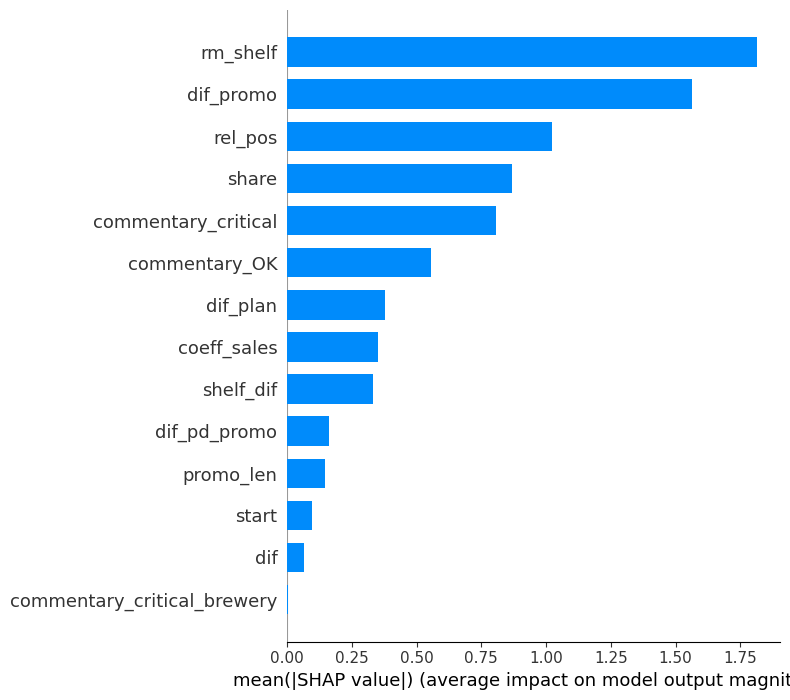

In [ ]:
#shap values
model = best_models['Logistic_Regression']['estimator']['estimator']
trf = data_transform(delete_columns = ['commentary_No', 'end', 'total_pcs'], scale = True, only_values=False)
X_drop = trf.transform(X_train_)

explainer = shap.LinearExplainer(model, X_drop)
shap_values = explainer.shap_values(X_drop)
shap.summary_plot(shap_values, feature_names=X_drop.columns, plot_type = 'bar')

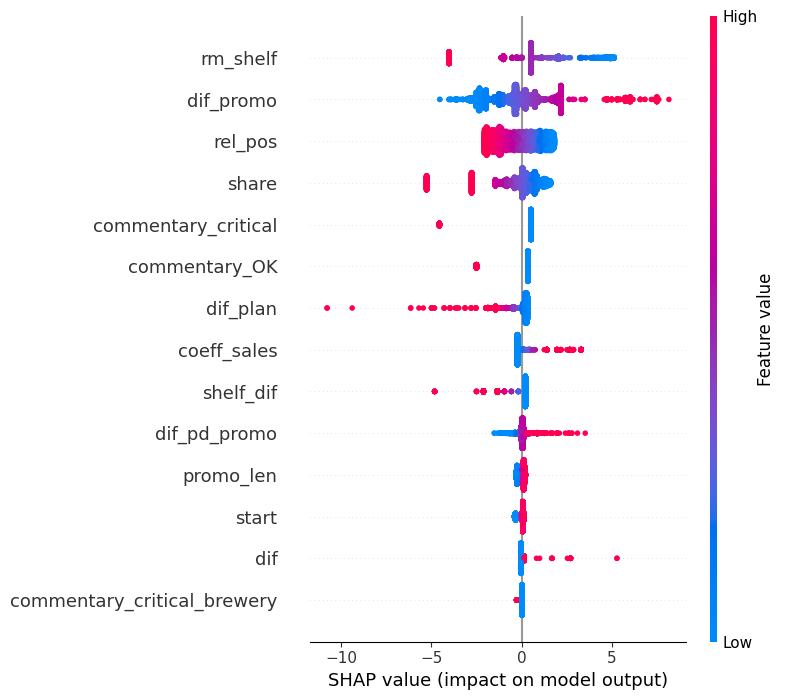

In [ ]:
shap.summary_plot(shap_values, X_drop, feature_names=X_drop.columns, plot_type = 'dot')

## Decision tree

### Geedy Search

We use cost complexity prunint technique to regulize Decistion Tree complexity

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DT

dt = DT(random_state = state)

#cost_complexity_pruning selects best ccp values for training the tree
path= dt.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path['ccp_alphas']

dt_params = {'estimator__ccp_alpha': ccp_alphas,
             'estimator__criterion': ['gini', 'entropy'],
             'estimator__class_weight': [None, 'balanced']}

CV_dt = grid_search(estimator= dt, params=dt_params, verbose=1)
save_performance(CV_dt, 'Decision_Tree_full')

Fitting 5 folds for each of 128 candidates, totalling 640 fits


Decision Tree has worse CV_roc_auc, but at the same better scores for other metrices

In [ ]:
best_scores

,CV_roc_auc,train_acc,val_acc,train_roc_auc,val_roc_auc
baseline,0.5,0.915346,0.915346,0.5,0.5
Logistic_Regression,0.991581,0.982277,0.976647,0.994041,0.993628
Decision_Tree_full,0.981347,0.991243,0.978315,0.995781,0.991094


best parameters

In [ ]:
best_models['Decision_Tree_full']['estimator']['estimator'].get_params()

{'ccp_alpha': 0.0032990409876730194,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

### Decision Tree feature importances

All the main features in Decistion Tree belong to relevant_columns set

In [ ]:

DT_importances = feature_importances(best_models, 'Decision_Tree_full')
print('Features importances based on total impurity decrease')
DT_importances

Features importances based on total impurity decrease


,importance,%
rm_shelf,0.577360,0.577
dif_promo,0.278201,0.278
share,0.089786,0.090
dif_pd_promo,0.032123,0.032
dif_plan,0.011272,0.011
rel_pos,0.011258,0.011
dif,0.000000,0.000
promo_len,0.000000,0.000
shelf_dif,0.000000,0.000
end,0.000000,0.000


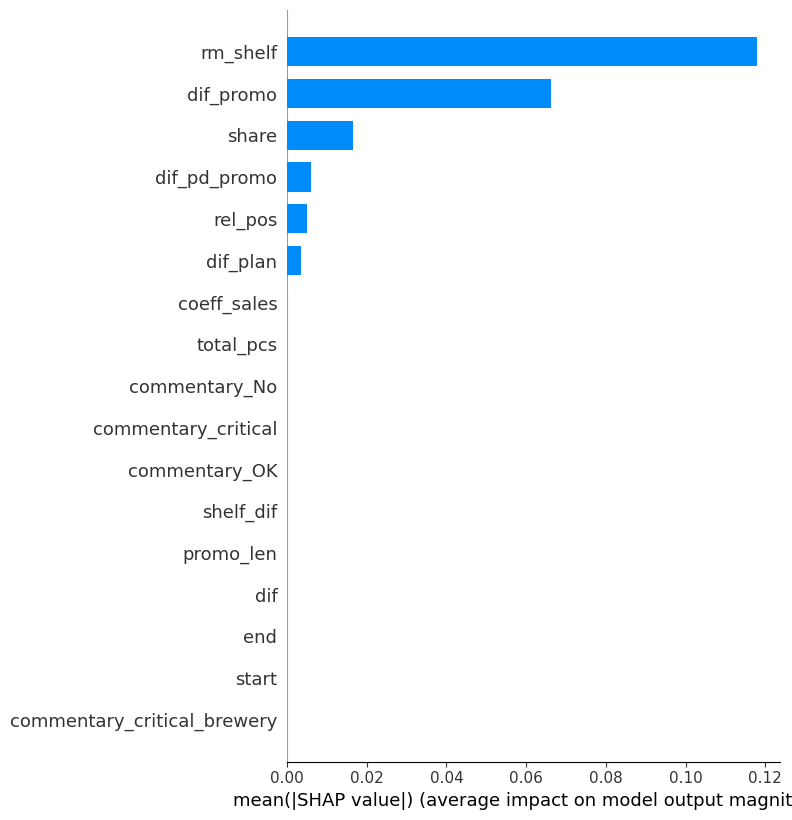

In [ ]:
#shap values
model = best_models['Decision_Tree_full']['estimator']['estimator']

model.fit(X_train, Y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap_values = shap_values[:,:,1]
shap.summary_plot(shap_values,  X_train, feature_names=X_train.columns, plot_type = 'bar')

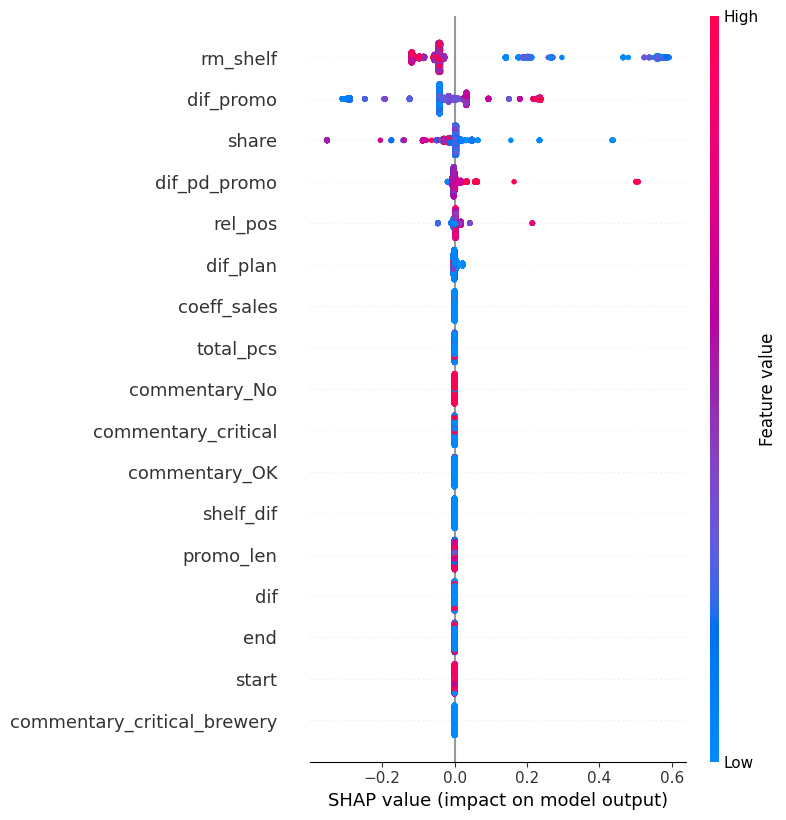

In [ ]:
shap.summary_plot(shap_values,  X_train, feature_names=X_train.columns, plot_type = 'dot')

### Truncated Decision Tree

From plots above it follows, that DT uses 6 features only. Due to that we can significantly simplify the model by restricting training set to those 6 features.

In [ ]:
dt = DT(random_state = state)
DT_sel_columns = DT_importances.query('importance > 0').index.values
dt_params = { 'transformer__select_columns': [DT_sel_columns],
             'estimator__ccp_alpha': ccp_alphas,
             'estimator__criterion': ['gini', 'entropy'],
             'estimator__class_weight': [None, 'balanced']}

CV_dt = grid_search(estimator= dt, params=dt_params, verbose=1)
save_performance(CV_dt, 'DT_truncated')

Fitting 5 folds for each of 128 candidates, totalling 640 fits


Except CV score, DT trained on truncated dataset shows the same performance. Deviation in CV score may be refered to the fact, that on the CV stage truncated tree may use a bit different set of features, rather than full Decision Tree.

Notably, Truncated Decision Tree uses features from full_promo report only. It means, that short_exp can be not used at all to obtain a model with practiacally acceptable performance.

best score

In [ ]:
best_scores

,CV_roc_auc,train_acc,val_acc,train_roc_auc,val_roc_auc
baseline,0.5,0.915346,0.915346,0.5,0.5
Logistic_Regression,0.991581,0.982277,0.976647,0.994041,0.993628
Decision_Tree_full,0.981347,0.991243,0.978315,0.995781,0.991094
DT_truncated,0.97981,0.991243,0.978315,0.995781,0.991094


best parameters

They are idential to Decistion Tree parameters

In [ ]:
best_models['DT_truncated']['estimator']['estimator'].get_params()

{'ccp_alpha': 0.0032990409876730194,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

### Feature importances

Feature importances differ a bit

In [ ]:
DT_importances = feature_importances(best_models, 'DT_truncated')
print('Features importances based on total impurity decrease')
DT_importances

Features importances based on total impurity decrease


,importance,%
rm_shelf,0.577360,0.577
dif_promo,0.295065,0.295
share,0.072921,0.073
dif_pd_promo,0.032123,0.032
dif_plan,0.011272,0.011
rel_pos,0.011258,0.011


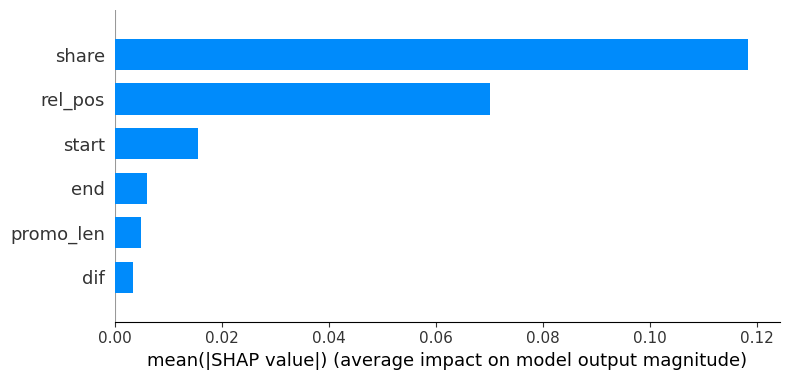

In [ ]:
#shap values
model = best_models['DT_truncated']['estimator']['estimator']
X_trun = X_train[DT_sel_columns]

model.fit(X_trun, Y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_trun)
shap_values = shap_values[:,:,1]
shap.summary_plot(shap_values,  X_trun, feature_names=X_train.columns, plot_type = 'bar')

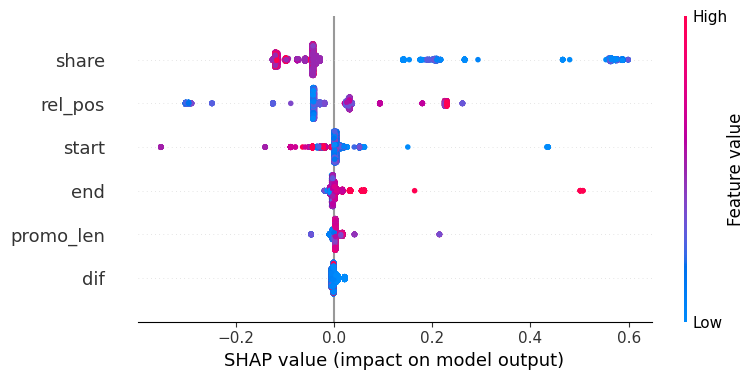

In [ ]:
shap.summary_plot(shap_values,  X_trun, feature_names=X_train.columns, plot_type = 'dot')

### Delete full Decistion Tree

Since truncated Decistion Tree performs almost as well as Decision Tree trained on the full dataset, there is not sense to keep unused features. So further we will consider truncated verstion of Decision Tree only.

In [ ]:
_ = best_models.pop('Decision_Tree_full')
best_models['Decision_Tree'] = best_models.pop('DT_truncated')
best_scores.drop(['Decision_Tree_full'], inplace = True)
best_scores.rename({'DT_truncated': 'Decision_Tree'}, inplace = True)

### Plot Decision Tree

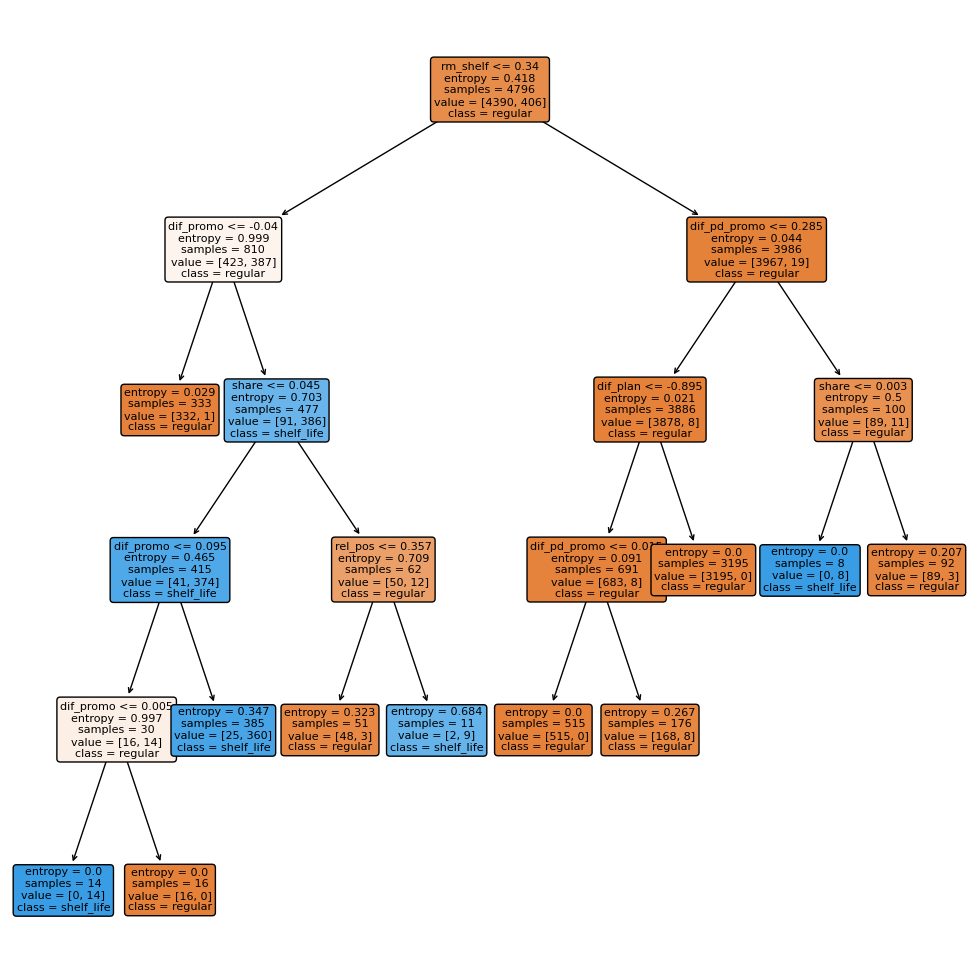

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8  # Define the position and size
ax = fig.add_axes([left, bottom, width, height])

_ = plot_tree(best_models['Decision_Tree']['estimator']['estimator'], feature_names=DT_sel_columns,class_names = ['regular', 'shelf_life'],ax = ax,rounded = True, filled = True, fontsize = 8)

### Delete full Decision Tree

truncated Decistion Tree shows the same performance, so there is not sence to sence to use all the columns for making predictions

In [ ]:
best_models['Decision_Tree'] = best_models['DT_truncated']
_ = best_models['Decision_Tree_full']
best_scores.rename(index = {'DT_truncated' : 'Decision_Tree'}, inplace = True)
best_scores.drop(index = ['Decision_Tree_full'], inplace = True)

## Random Forest

### Greedy Search

As in case of Decistion Tree we use ccp_alpha to impose constrain on the model complexity

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RF

alpha = best_models['Decision_Tree']['estimator']['estimator'].ccp_alpha
rf = RF(n_estimators = 100, random_state=state, warm_start = True, ccp_alpha=alpha)

#find optimal n_estimators for fixed ccp_lpha
n_estimators = {'estimator__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
CV_rf = grid_search(X=X_train_, Y=Y_train, estimator=rf, params = n_estimators, verbose = 1)


#find optimal ccp_alpha and criterion for fixed n_estimators
rf = CV_rf[0].named_steps['estimator']
rf_params = {'estimator__ccp_alpha': ccp_alphas,
             'estimator__criterion': ['gini', 'entropy'],
             'estimator__class_weight': [None, 'balanced']
             }

CV_rf = grid_search(X=X_train_, Y=Y_train, estimator=rf, params = rf_params, verbose = 1)
save_performance(CV_rf, 'Random_Forest')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 128 candidates, totalling 640 fits


Random Forest performces much better than all other models trained before that and shows almost perfect accuracy for train and validation datasets

In [ ]:
best_scores

,CV_roc_auc,train_acc,val_acc,train_roc_auc,val_roc_auc
baseline,0.5,0.915346,0.915346,0.5,0.5
Logistic_Regression,0.991581,0.982277,0.976647,0.994041,0.993628
Decision_Tree,0.97981,0.991243,0.978315,0.995781,0.991094
Random_Forest,0.995593,0.996455,0.994162,0.999929,0.997408


best parameters

In [ ]:
best_models['Random_Forest']['estimator']['estimator'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0005987895896152777,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': True}

### Randomr Forest feature importances

Random Forest has more diversificated feature importances distribution than Decistion Tree, what implies better generalization of the model.  But top two features are the same - dif_promo and rm_shelf.Also all the top features belong to relevant_columns set.

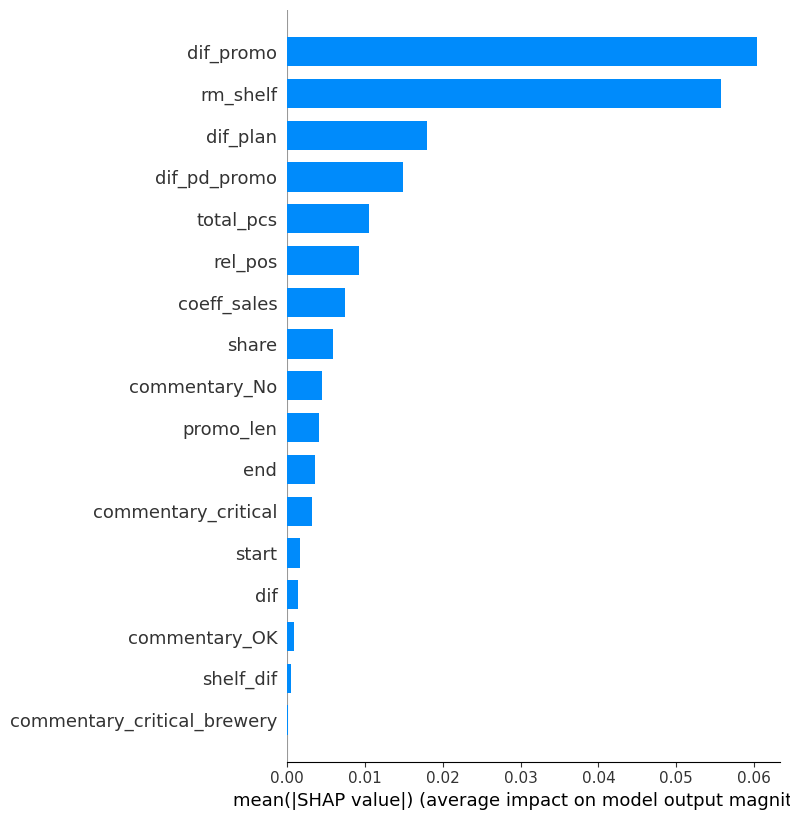

In [ ]:
#shap values
model = best_models['Random_Forest']['estimator']['estimator']

model.fit(X_train, Y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap_values = shap_values[:,:,1]
shap.summary_plot(shap_values,  X_train, feature_names=X_train.columns, plot_type = 'bar')

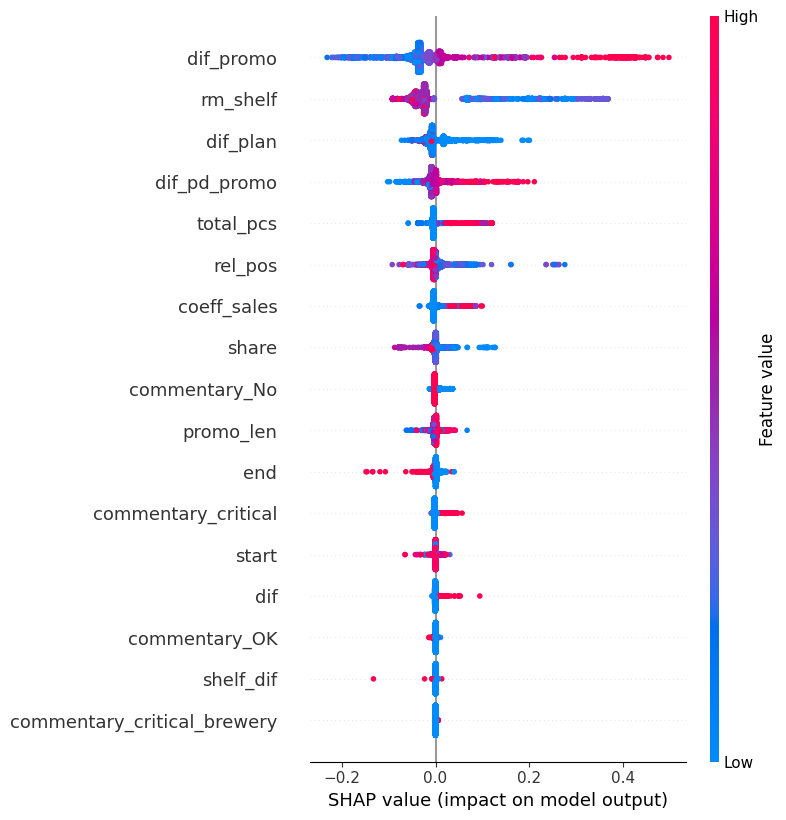

In [ ]:
shap.summary_plot(shap_values,  X_train, feature_names=X_train.columns, plot_type = 'dot')

## LGBM

### Greedy Search

In [ ]:
from lightgbm import LGBMClassifier as LGBM


lgbm = LGBM(is_unbalance=True, importance_type = 'gain', random_state = state, verbose = -1)

max_depth = np.array([1,2,3,5,10,15])
lgbm_params = {'estimator__num_leaves':  2*max_depth,
               'estimator__max_depth': max_depth,
               'estimator__num_iterations':[100,300,500],
               'estimator__learning_rate':[0.1,0.01]
               }

CV_lgbm = grid_search(X = X_train_, Y = Y_train, estimator=lgbm,params=lgbm_params,verbose=1)
lgbm_params = {'estimator__is_unbalance':[True, False]}

CV_lgbm = grid_search(X = X_train_, Y = Y_train, estimator=CV_lgbm[0]['estimator'], params=lgbm_params, verbose=1)
save_performance(CV_lgbm,'LGBM', best_scores = best_scores, best_models = best_models)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


LGBM performs almost as well as Random Forest

In [ ]:
best_scores

,CV_roc_auc,train_acc,val_acc,train_roc_auc,val_roc_auc
baseline,0.5,0.915346,0.915346,0.5,0.5
Logistic_Regression,0.991581,0.982277,0.976647,0.994041,0.993628
Decision_Tree,0.97981,0.991243,0.978315,0.995781,0.991094
Random_Forest,0.995593,0.996455,0.994162,0.999929,0.997408
LGBM,0.994811,0.995621,0.989992,0.999979,0.998615


best parameters

In [ ]:
best_models['LGBM']['estimator']['estimator'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 20,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'is_unbalance': True,
 'verbose': -1,
 'num_iterations': 500}

### LGBM Feature importances

LGBM model also mostly relies on feature from relevant_columns set

 99%|===================| 4756/4796 [01:11<00:00]       

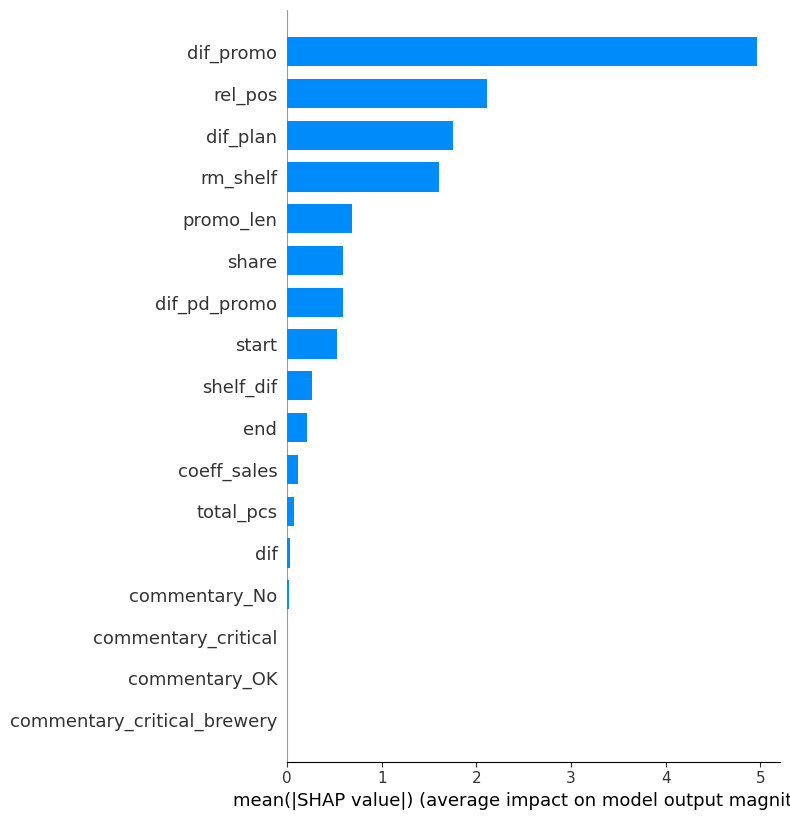

In [ ]:
model = best_models['LGBM']['estimator']['estimator']
explainer = shap.TreeExplainer(model, X_train, feature_perturbation="interventional", model_output="raw")
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type = 'bar')

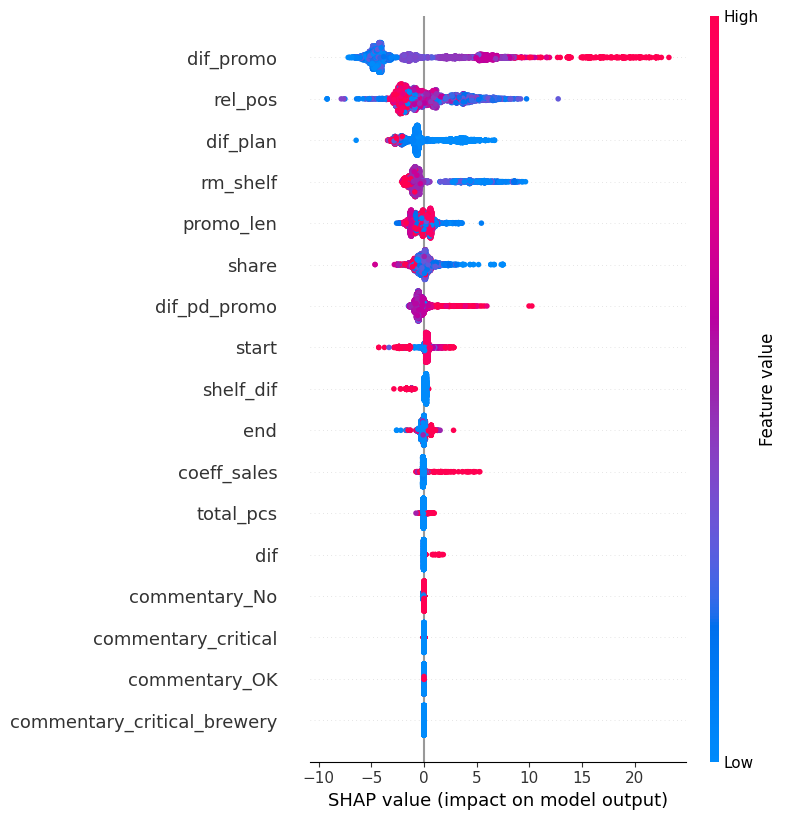

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type = 'dot')

## CatBoost


### Greedy search

CatBoost usually performs well with default parameters. So we will make greedy search for learning-rate only and leave other hyperparameters untouched.

In [ ]:
#!pip install catboost

from catboost import CatBoostClassifier as CB

#scale_pos_weiht assigns higher weight to the minority class during training
scale_pos_weight = (Y_train.count()/Y_train.sum())
cat = CB(random_seed=state, verbose=0)

cat_params = {'estimator__learning_rate': [0.5, 0.1,  0.05, 0.03, 0.01, 0.005, 0.001], 'estimator__scale_pos_weight': [None, scale_pos_weight]}

CV_cat = grid_search(X = X_train_, Y = Y_train, estimator=cat, params = cat_params, verbose = 1)
save_performance(CV_cat, 'CatBoost', best_models = best_models, best_scores = best_scores)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


even withouth special hyperparameter tunining CatBoost performs very well

In [ ]:
best_scores

,CV_roc_auc,train_acc,val_acc,train_roc_auc,val_roc_auc
baseline,0.5,0.915346,0.915346,0.5,0.5
Logistic_Regression,0.991581,0.982277,0.976647,0.994041,0.993628
Decision_Tree,0.97981,0.991243,0.978315,0.995781,0.991094
Random_Forest,0.995593,0.996455,0.994162,0.999929,0.997408
LGBM,0.994811,0.995621,0.989992,0.999979,0.998615
CatBoost,0.995146,0.992077,0.984987,0.999315,0.997212


best parameters

In [ ]:
CV_cat[0]['estimator'].get_params()

{'learning_rate': 0.01,
 'random_seed': 0,
 'verbose': 0,
 'scale_pos_weight': 11.812807881773399}

### Feature importances

CatBoost has realistic shap_values distribution. So no anomalies in feature importances are detected.

100%|===================| 4792/4796 [04:15<00:00]       

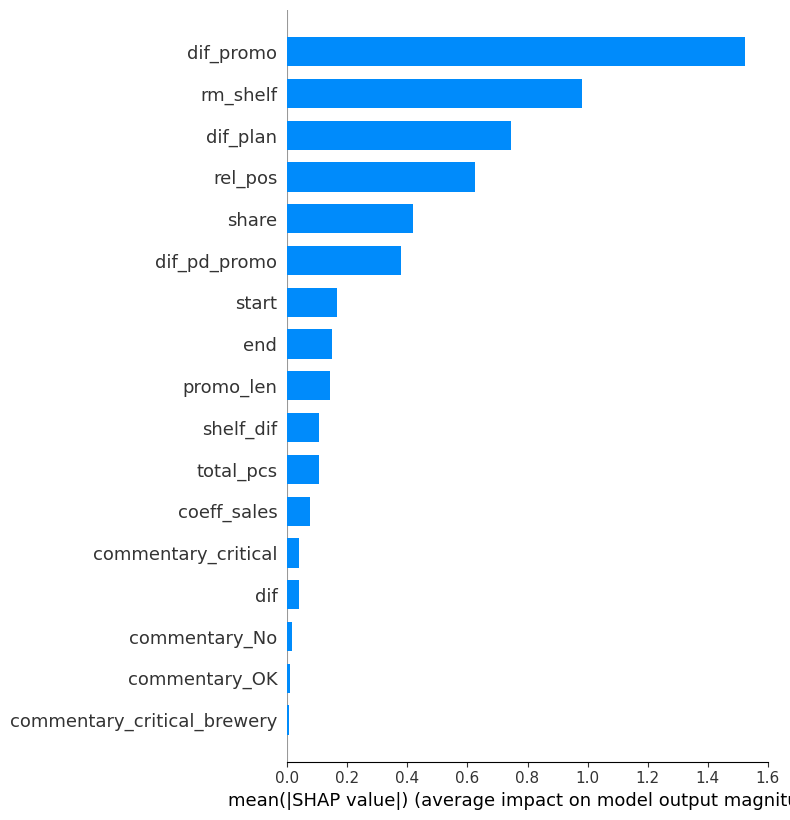

In [ ]:
model = CV_cat[0]['estimator']
explainer = shap.TreeExplainer(model, X_train, feature_perturbation="interventional", model_output="raw")
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type = 'bar')

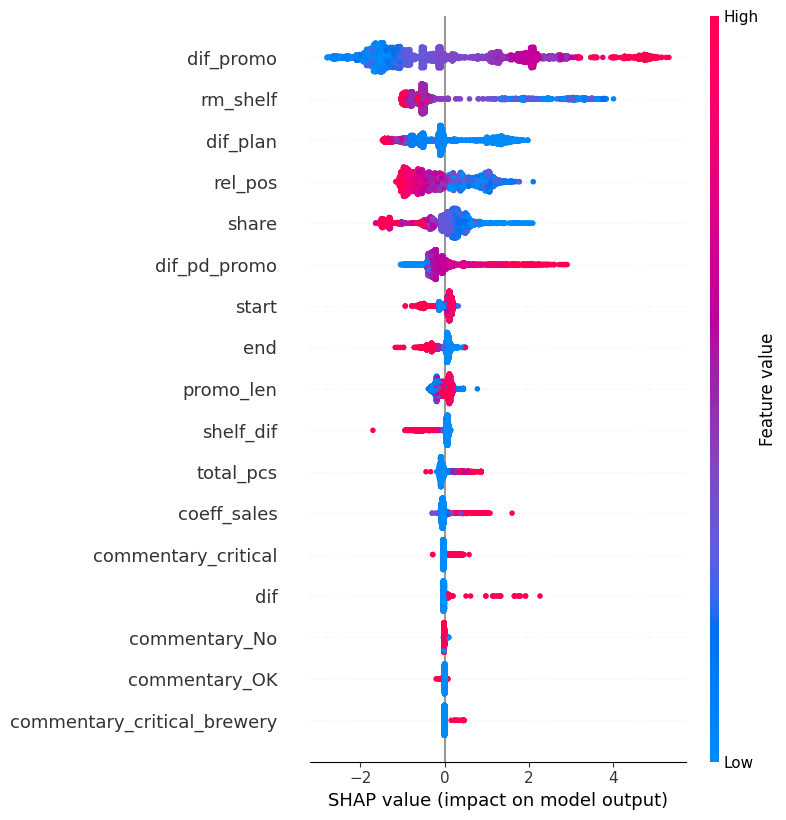

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type = 'dot')

## Perceptron

### Perceptron class definition

In [ ]:
import torch.nn as nn
from torch.nn import BCELoss
from torch.optim import Adam
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin


def create_weights(target):
   #during calculating model loss weights proprotional to class shares are assigned to each outcome. This help to navigate unbalancing dataset issue
    weights = target.numpy()
    weights = weights.astype(int)
    coef = weights.shape[0]/(2*np.bincount(weights))
    weights = torch.tensor(weights, dtype=torch.float64)
    weights.apply_(lambda x: coef[int(x)])
    return weights

def to_tensor(X_input):
    if type(X_input) in (pd.core.frame.Series,pd.core.frame.DataFrame):
      X_tensor = torch.FloatTensor(X_input.values)
    else:
      X_tensor = torch.FloatTensor(X_input)
    return X_tensor

class Perceptron(nn.Module):

    def __init__(self, n_neurons, actv_fun, n_input, initialize):
        super(Perceptron, self).__init__()

        self.n_neurons = n_neurons

        assert actv_fun in ['ReLU', 'Sigmoid'], 'actv_fun should be ReLU or Sigmoid'
        self.actv_fun = actv_fun
        if self.actv_fun == 'ReLU':
          self.actv_fun_ = nn.ReLU()
        else:
          self.actv_fun_ = nn.Sigmoid()

        self.n_input = n_input
        self.initialize = initialize
        self.sigmoid = nn.Sigmoid()


        self.model = nn.Sequential(
                        nn.Linear(self.n_input, self.n_neurons),
                        self.actv_fun_,
                        nn.Linear(self.n_neurons, 1),
                        self.sigmoid
                        )

        #Initialize model wieght. Using of initialization methods depends on the activation function

        if self.initialize:
          for layer in self.model:
            if isinstance(layer, nn.Linear):
              if self.actv_fun == 'ReLU':
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
              if self.actv_fun == 'Sigmoid':
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, input):
        input_tensor = to_tensor(input)
        x = self.model(input_tensor)
        return x

class TorchPerceptron(BaseEstimator, ClassifierMixin):

  def __init__(self, n_neurons=50, actv_fun='Sigmoid', n_epoch = 20, batch_size = 64,  lr = 0.01, unbalanced = False, initialize = False, device  = 'cpu'):
    super(TorchPerceptron, self).__init__()
    self.n_neurons = n_neurons
    self.actv_fun = actv_fun
    self.n_epoch = n_epoch
    self.batch_size = batch_size
    self.unbalanced = unbalanced
    self.initialize = initialize
    self.lr = lr
    self.device = device
    self.model = None


  def fit(self, X_input, Y_input):
    X_tensor = to_tensor(X_input)
    Y_tensor = to_tensor(Y_input)

    X_tensor.to(self.device)
    Y_tensor.to(self.device)

    self.n_input = X_tensor.shape[1]
    self.model = Perceptron(n_neurons = self.n_neurons, actv_fun = self.actv_fun, n_input= self.n_input, initialize=self.initialize)
    self.model.to(self.device)
    self.optimizer = Adam(params=self.model.parameters(), lr = self.lr)


    dataset = TensorDataset(X_tensor, Y_tensor)
    loader = DataLoader(dataset, batch_size=self.batch_size, drop_last = False, shuffle = True)
    for k in range(self.n_epoch):
      for batch, target in loader:
        if self.unbalanced:
          weights = create_weights(target)
        else:
          weights = torch.ones(target.shape[0])
        L = BCELoss(weight=weights)
        L.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(batch)
        loss = L(outputs.squeeze(), target)
        loss.backward()
        self.optimizer.step()
    self.classes_ = np.unique(Y_tensor)

  def predict_proba(self, X_input):
    X_tensor = to_tensor(X_input)
    result = self.model(X_tensor)
    result = result.detach().numpy()
    result = np.concatenate((1-result, result), axis = 1)
    return result

  def predict(self, X_input):
    X_tensor = to_tensor(X_input)
    result = self.predict_proba(X_tensor)[:,1]
    result = np.round(result)
    return result


### Perceptron greedy search

Estimate parameters sequentially. To speed up training we use 3-fold cross-validation


In [ ]:
#for result repducivity specify state of random number initializer
torch.manual_seed(state)

perc = TorchPerceptron(n_epoch=50, lr=0.001)

params_perc = {'estimator__actv_fun': ['Sigmoid', 'ReLU'], 'estimator__n_neurons': [50+i*50 for i in range(20)], 'transformer__scale': [True]}
cv = 3
_ = grid_search(estimator=perc, params=params_perc, cv= cv)


n_estimate = _[0]['estimator'].n_neurons
params_perc = {'estimator__n_neurons': [n_estimate + 10*i for i in range(-4,5)], 'estimator__lr': [0.01, 0.001, 0.0005]}

_ = grid_search(estimator = _[0]['estimator'], transformer=_[0]['transformer'], params = params_perc, cv = cv)


params_perc= {'estimator__unbalanced': [True, False], 'estimator__initialize': [True, False], 'estimator__batch_size':[32, 64, 128], 'estimator__n_epoch': [10, 20, 50, 100]}

CV_perc = grid_search(estimator = _[0]['estimator'], transformer=_[0]['transformer'], params = params_perc, cv = cv)
save_performance(CV_perc, 'Perceptron_full', best_scores = best_scores, best_models = best_models)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


best_scores

Perceptrom is slightly better than Decision Tree and Logistic Regression, but worse than Random Forest and boosting methods

In [ ]:
best_scores

,CV_roc_auc,train_acc,val_acc,train_roc_auc,val_roc_auc
baseline,0.5,0.915346,0.915346,0.5,0.5
Logistic_Regression,0.991581,0.982277,0.976647,0.994041,0.993628
Decision_Tree,0.97981,0.991243,0.978315,0.995781,0.991094
Random_Forest,0.995593,0.996455,0.994162,0.999929,0.997408
LGBM,0.994811,0.995621,0.989992,0.999979,0.998615
CatBoost,0.995146,0.992077,0.984987,0.999315,0.997212
Perceptron_full,0.993038,0.991451,0.979983,0.996488,0.994647


best parameters

In [ ]:
best_models['Perceptron_full']['estimator']['estimator'].get_params()

{'actv_fun': 'ReLU',
 'batch_size': 64,
 'device': 'cpu',
 'initialize': True,
 'lr': 0.0005,
 'n_epoch': 100,
 'n_neurons': 40,
 'unbalanced': False}

### Perceptron feature importances

Several anomalies were detected in the Perceptron feature importances distribtuion:

1. From the dot plot it follows, that lack of any commentary from the shotr expiration report in a promo row(in such case commentary_No ==1) increases probability, that corresponding discount is shelf_life. What is contradictory, since lack of any commentary indicates, that promo product hadn't been included in the short expiration report, due to that it is very unlikely, that it was approved shelf_life promo for that product.
2. The same situation is with commentary_critical feature. Presence of this comment should increases shelf_life probability, but not otherwise.

So taking mentioned considerations into account and to make our model more realistic, it is reasonable to drop commentary_No and commentary_critical from the dataset, even if it will worse model performance.


PermutationExplainer explainer: 4797it [00:44, 92.67it/s]                           


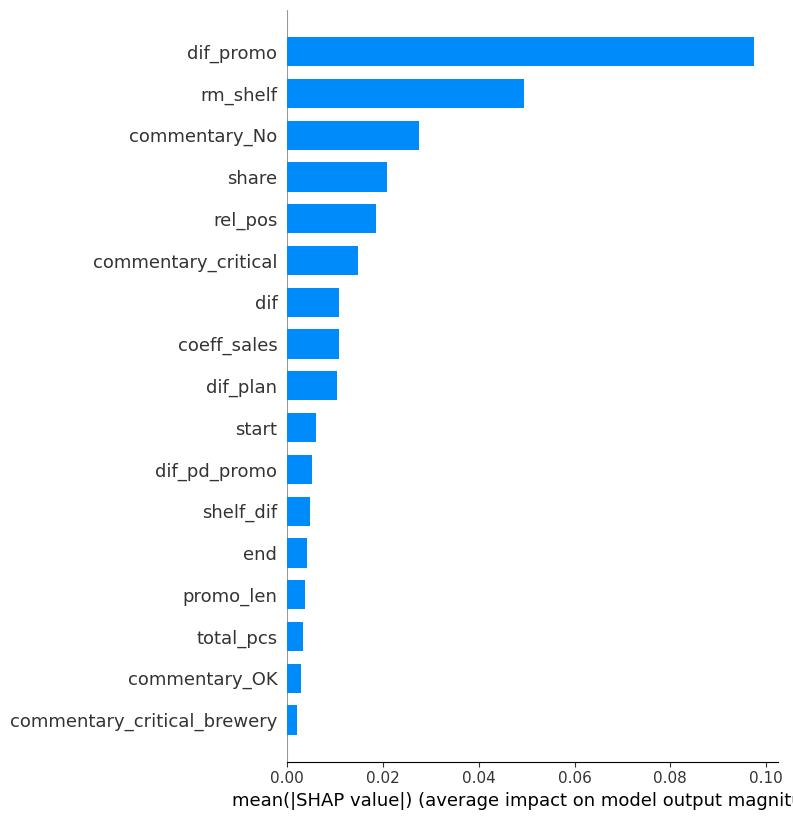

In [ ]:
model = best_models['Perceptron_full']['estimator']['estimator'].model
trf = data_transform(scale = True, only_values=False)
X_prc = trf.transform(X_train_)

explainer = shap.Explainer(model, X_prc)
shap_values = explainer.shap_values(X_prc)
shap.summary_plot(shap_values, X_prc, plot_type='bar', feature_names=X_prc.columns)

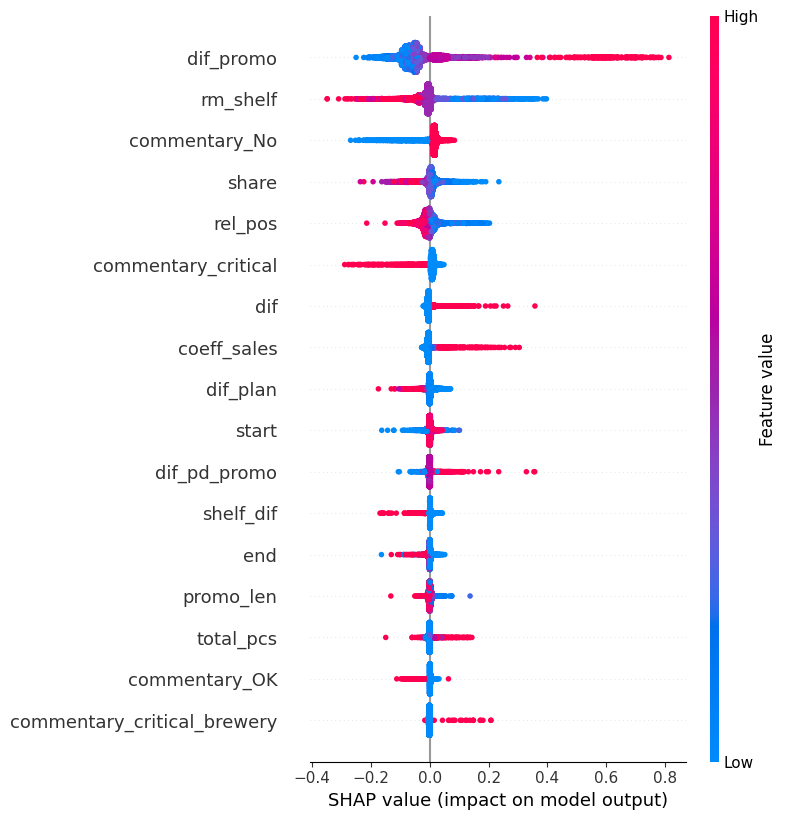

In [ ]:
shap.summary_plot(shap_values, X_prc, plot_type='dot', feature_names=X_prc.columns)

In [ ]:
#for result repducivity specify state of random number initializer
torch.manual_seed(state)
estimator =clone(best_models['Perceptron_full']['estimator']['estimator'])

params_perc= {'transformer__delete_columns': [['commentary_No', 'commentary_critical']], 'transformer__scale': [True]}

CV_perc = grid_search(estimator = estimator, params = params_perc, cv = 3)
save_performance(CV_perc, 'Perceptron', best_scores = best_scores, best_models = best_models)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


dropping 'commentary_No', 'commentary_critical' from the training dataset decreases most of model metrices, but not too much. However after that feature importances look rather more realistic

In [ ]:
best_scores

,CV_roc_auc,train_acc,val_acc,train_roc_auc,val_roc_auc
baseline,0.5,0.915346,0.915346,0.5,0.5
Logistic_Regression,0.991581,0.982277,0.976647,0.994041,0.993628
Decision_Tree,0.97981,0.991243,0.978315,0.995781,0.991094
Random_Forest,0.995593,0.996455,0.994162,0.999929,0.997408
LGBM,0.994811,0.995621,0.989992,0.999979,0.998615
CatBoost,0.995146,0.992077,0.984987,0.999315,0.997212
Perceptron_full,0.993038,0.991451,0.979983,0.996488,0.994647
Perceptron,0.990012,0.991868,0.979149,0.996192,0.992904


In [ ]:
model = best_models['Perceptron']['estimator']['estimator'].model
trf = data_transform(scale = True, only_values=False, delete_columns = ['commentary_No', 'commentary_critical'])
X_prc = trf.transform(X_train_)

explainer = shap.Explainer(model, X_prc)
shap_values = explainer.shap_values(X_prc)
shap.summary_plot(shap_values, X_prc, plot_type='bar', feature_names=X_prc.columns)

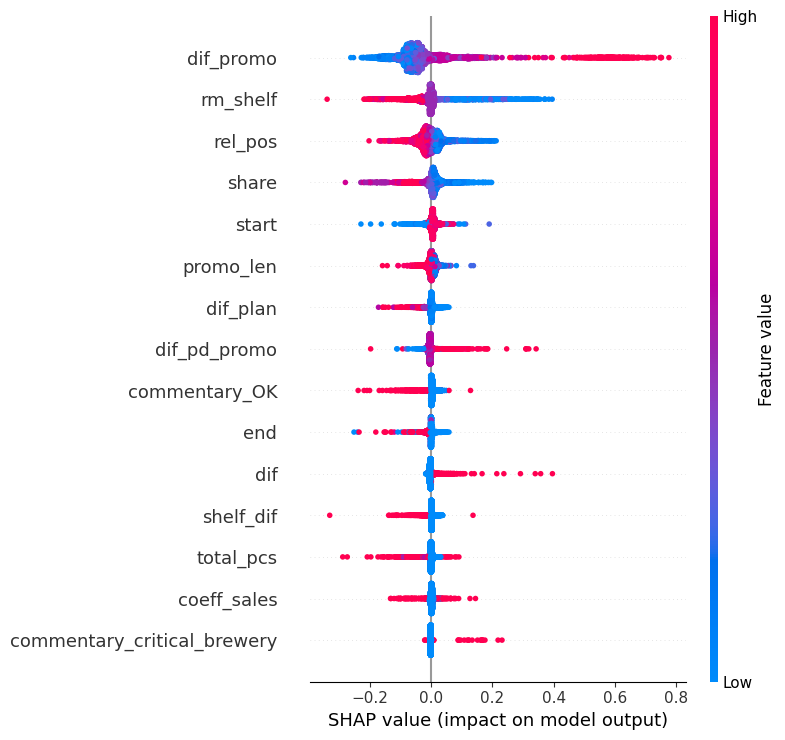

In [ ]:
shap.summary_plot(shap_values, X_prc, plot_type='dot', feature_names=X_prc.columns)

Drop Perceptron_full

In [ ]:
best_scores.drop('Perceptron_full', inplace = True)
_ = best_models.pop('Perceptron_full')

# Results

To get more insights into the models work, we obtain True Positive Rate(TPR), True Negative Rate(TNR) and Balanced accuracy = (TPR+TNR)/2

In [ ]:
from sklearn.metrics import confusion_matrix
torch.manual_seed(state)

acc_rates = pd.DataFrame( columns = ['val_TP', 'val_TN', 'val_Balanced_acc'])
acc_rates.loc['baseline'] = [1, 0, 0.5]

for model_name in ['Logistic_Regression', 'Decision_Tree', 'Random_Forest', 'LGBM', 'CatBoost', 'Perceptron']:
  model = best_models[model_name]['estimator']

  Y_pred = model.predict(X_val_)
  matrix = confusion_matrix(Y_val,Y_pred)
  TN = matrix[0][0]/(matrix[0][0]+matrix[0][1])
  TP = matrix[1][1]/(matrix[1][0]+matrix[1][1])
  Balanced_acc = 0.5*(TP+TN)
  acc_rates.loc[model_name] = [TP, TN, Balanced_acc]
acc_rates

,val_TP,val_TN,val_Balanced_acc
baseline,1.000000,0.000000,0.500000
Logistic_Regression,0.803922,0.992707,0.898314
Decision_Tree,0.901961,0.985415,0.943688
Random_Forest,0.990196,0.994531,0.992363
LGBM,0.931373,0.995442,0.963407
CatBoost,0.990196,0.984503,0.987350
Perceptron,0.843137,0.991796,0.917467


Let's merge acc_rates and best_scores to get cummulative representation of models perfromance.

We consider metrices for validation sets only. So in the final dataframe all the models are trained on the training datasets and evaluated on the evaluation ones. Cross-Validation for CV_roc_auc is done on the training dataset.

In [ ]:
performance = best_scores[['CV_roc_auc', 'val_acc', 'val_roc_auc']].merge(acc_rates, left_index = True, right_index = True)
performance = performance[[ 'val_acc', 'val_TP', 'val_TN',
       'val_Balanced_acc', 'val_roc_auc', 'CV_roc_auc' ]]
performance.columns = [ 'acc', 'TP', 'TN',
       'Balanced_acc', 'roc_auc', 'CV_roc_auc' ]

In [ ]:
performance

,acc,TP,TN,Balanced_acc,roc_auc,CV_roc_auc
baseline,0.915346,1.000000,0.000000,0.500000,0.5,0.5
Logistic_Regression,0.976647,0.803922,0.992707,0.898314,0.993628,0.991581
Decision_Tree,0.978315,0.901961,0.985415,0.943688,0.991094,0.97981
Random_Forest,0.994162,0.990196,0.994531,0.992363,0.997408,0.995593
LGBM,0.989992,0.931373,0.995442,0.963407,0.998615,0.994811
CatBoost,0.984987,0.990196,0.984503,0.987350,0.997212,0.995146
Perceptron,0.979149,0.843137,0.991796,0.917467,0.992904,0.990012


To provide a better view on the model results, we calculated relative scores for every metric. In our case relative score measures how much of the full potential improvement the model uses, where full potential improvement is obtained by comparing performance of the baseline estimator with perfect classifier. Such relative scores allow to perform better comparing between trained model and baseline classifier.

relative_score = used_potential_improvement/full_potential_improvement

used_potential_improvement = (score - baseline_score)\
full_potential_improvement = (1 - base_line_score)

relative_score > 0 - model is better than baseline classifier\
relative_score = 0 - model is the same as baseline classifier\
relative_score < 0 - model is worse than baseline classifier\



In [ ]:

baseline = performance.loc['baseline']
potential_scores = (performance - baseline)/(1 - baseline)
potential_scores.fillna(0, inplace = True)


In [ ]:
potential_scores

,acc,TP,TN,Balanced_acc,roc_auc,CV_roc_auc
baseline,0.0,0.0,0.000000,0.000000,0.0,0.0
Logistic_Regression,0.724138,-inf,0.992707,0.796629,0.987256,0.983162
Decision_Tree,0.743842,-inf,0.985415,0.887376,0.982188,0.95962
Random_Forest,0.931034,-inf,0.994531,0.984727,0.994817,0.991187
LGBM,0.881773,-inf,0.995442,0.926815,0.99723,0.989622
CatBoost,0.82266,-inf,0.984503,0.974699,0.994423,0.990293
Perceptron,0.753695,-inf,0.991796,0.834933,0.985808,0.980025
